# Mapping of registered lightning arroud CG stroke

In [6]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from datetime import timezone
import datetime as dt
import json
from IPython.display import Image as ImageDisp
from pandas import DataFrame
import string
import os
import glob
import matplotlib.pyplot as plt
#%pylab inline --no-import-all
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import time
os.environ['TZ'] = 'UTC'
time.tzset()
import matplotlib.colors as colors
import json
import matplotlib

hdr_t = np.dtype([
    ('magic', 'u4'),
    ('id', 'u4'),
    ('timestamp', 'u4'),
    ('gps_flags', 'u1'),
    ('gps_sat', 'u1'),
    ('gps_lat', 'f4'),
    ('gps_long', 'f4'),
    ('gps_alt', 'u2'),
    ('gps_hour', 'u1'),
    ('gps_min', 'u1'),
    ('gps_sec', 'u1'),
    ('num_energy_data', 'u2'),
], align=True)

energy_data_t = np.dtype([
    ('info', 'u1'),
    ('timestamp_us', 'u4'),
    ('energy', 'f4'),
], align=True)

def read_rt_dat_file(filename):
    ret_dtype = np.dtype([
        ('time', 'u4'),
        ('time_us', 'u4'),
        ('energy', 'f4'),
        ('info', 'u1'),
        ('gps_lat', 'f4'),
        ('gps_long', 'f4'),
        ('gps_alt', 'u2')
    ])
    
    ret = np.zeros(0, dtype=ret_dtype)
    pieces = []

    with open(filename, 'r') as f:
        while True:
            try:
                hdr = np.fromfile(f, dtype=hdr_t, count=1)[0]
            except IndexError:
                break
            if hdr['magic'] != 0xaaaabbbb:
                raise Exception('corrupted data, magic mismatch')
                
            energy_data = np.fromfile(f, dtype=energy_data_t, count=hdr['num_energy_data'])
            piece = np.zeros(len(energy_data), dtype=ret_dtype)
            piece['time'] = hdr['timestamp']
            piece['time_us'] = energy_data['timestamp_us']
            piece['energy'] = energy_data['energy']
            piece['info'] = energy_data['info']
            piece['gps_lat'] = hdr['gps_lat']
            piece['gps_long'] = hdr['gps_long']
            piece['gps_alt'] = hdr['gps_alt']
            pieces.append(piece)
    return np.concatenate(pieces)

In [482]:
lat=50.1006197
lon=10.7797819

#lat=51.7656581
#lon=10.6106400
#start=pd.Timestamp('2023-02-01 12:00') # Winter s dirou
#end=pd.Timestamp('2023-02-02 2:00')

# Please comment not relevant time intervals
#start=pd.Timestamp('2023-01-13 12:00') # Winter
#end=pd.Timestamp('2023-01-13 14:00')

#start=pd.Timestamp('2023-02-01 20:00') # Winter
#end=pd.Timestamp('2023-02-02 2:00')

#start=pd.Timestamp('2023-02-25 08:00') # Winter
#end=pd.Timestamp('2023-02-25 15:00')

#start=pd.Timestamp('2023-06-08 10:00') # Sommer
#end=pd.Timestamp('2023-06-08 18:00')

start=pd.Timestamp('2023-11-24 07:00') # Winter
end=pd.Timestamp('2023-11-24 18:00')

start=pd.Timestamp('2023-12-21 17:00') # Winter
end=pd.Timestamp('2023-12-21 23:00')

#start=pd.Timestamp('2023-12-22 19:00') # Winter
#end=pd.Timestamp('2023-12-22 23:50')

sitename = str(start)
radius_error = 1.4
#radius_error = 5.6

BLITZ_DIST = 150


In [483]:
# URL
# https://data.blitzortung.org/Data/Protected/ # Tohle stahovani nefunguje

print(start, end, lat, lon)
region=1
#region=18
#region=19
#region=4 # Asia

### url for json data preparation
url=[]

for i in range(0,int(np.ceil((end-start).total_seconds()/600)+1)):
    next=start+ pd.Timedelta(minutes=i*10)
    url.append('http://data.blitzortung.org/Data/Restricted/Strikes_%01d/%02d/%02d/%02d/%02d/%02d.json' % (region, next.year, next.month, next.day, next.hour, np.floor((next.minute)//10)*10))

import requests
blitz=pd.DataFrame()
for i in range(len(url)):
    try:
        html = requests.get(url[i]).content
        blitz_part = pd.read_json(html.decode("utf-8"),lines=True)
        #blitz_part.drop(columns=['status','sig'], inplace=True)#,'region', 
        blitz = pd.concat([blitz,blitz_part])
    except:
        print("No data", url[i])
        pass
blitz.set_index(['time'], inplace=True)

### reduction of too distant events
blitz=blitz[(blitz['lat']>(lat-2) )&(blitz['lat']<(lat+2) )]
blitz=blitz[(blitz['lon']>(lon-3.5) )&(blitz['lon']<(lon+3.5) )]

### calculation of distance of events from station
#from math import radians, cos, sin, asin, sqrt, atan2, degrees

try:
    blitz.drop(columns=['alt','pol','region'], inplace=True)
except:
    print('No columns to drop (alt, pol, region)')
    pass
#blitz['time']=blitz.index    
blitz['date'] = pd.to_datetime(blitz.index, unit='ns')
blitz.reset_index(inplace=True)
blitz.set_index('date', inplace=True)

print('end')

2023-12-21 17:00:00 2023-12-21 23:00:00 50.1006197 10.7797819
end


In [484]:
# Store lightning data to local file
#blitz.to_csv('./data/blitz_'+str(start)+'bourka.csv')


In [485]:
# Load of lightning data

blitz = pd.read_csv('./data/blitz_'+sitename+'bourka.csv', sep=',', low_memory=False, on_bad_lines='skip')


In [486]:
# Reduction of distant lightnings

blitz['lonRad']=np.radians(blitz.lon)
blitz['latRad']=np.radians(blitz.lat)
lonRad=np.radians(lon)
latRad=np.radians(lat)
blitz['DlonRad']=lonRad-blitz.lonRad
blitz['DlatRad']=latRad-blitz.latRad
blitz['a']=np.sin(blitz.DlatRad/2.)**2. + np.cos(blitz.latRad) * np.cos(latRad) * np.sin(blitz.DlonRad/2.)**2.
blitz['km'] = 2. * np.arcsin(np.sqrt(blitz.a))*6378.
blitz = blitz.loc[blitz['km'] <= BLITZ_DIST]
blitz.reset_index(inplace=True)

https://overpass-turbo.eu/#

// @name tower

/*
This has been generated by the overpass-turbo wizard.
The original search was:
“ man_made = tower”
*/
[out:json][timeout:25];
// gather results
nwr["man_made"="tower"](48.7022575, 7.0337444,51.5979428, 13.5376508);
// print results
out center;


// @name wind_turbine

/*
This has been generated by the overpass-turbo wizard.
The original search was:
“generator:method=wind_turbine”
*/
[out:json][timeout:25];
// gather results
nwr["generator:source"="wind"](48.7022575, 7.0337444,51.5979428, 13.5376508);
// print results
out center;

In [487]:
json_file = '/home/kakl/vanice/data/windturbine.geojson'
#json_file = '/home/kakl/vanice/data/windturbine_big.geojson'

with open(json_file) as f:
    data = json.load(f)
windturbines = pd.json_normalize(data,'features')

windturbines['lon'] = windturbines['geometry.coordinates'].apply(lambda x: x[0][0] if isinstance(x[0], (list, np.ndarray)) else x).apply(lambda x: x[0])
windturbines['lat'] = windturbines['geometry.coordinates'].apply(lambda x: x[0][0] if isinstance(x[0], (list, np.ndarray)) else x).apply(lambda x: x[1])



In [488]:
# Reduction of wind-turbines points

windturbines['lonRad']=np.radians(windturbines.lon)
windturbines['latRad']=np.radians(windturbines.lat)
lonRad=np.radians(lon)
latRad=np.radians(lat)
windturbines['DlonRad']=lonRad-windturbines.lonRad
windturbines['DlatRad']=latRad-windturbines.latRad
windturbines['a']=np.sin(windturbines.DlatRad/2.)**2. + np.cos(windturbines.latRad) * np.cos(latRad) * np.sin(windturbines.DlonRad/2.)**2.
windturbines['km'] = 2. * np.arcsin(np.sqrt(windturbines.a))*6378.
windturbines = windturbines.loc[windturbines['km'] <= BLITZ_DIST]
windturbines.reset_index(inplace=True)

In [489]:
# Identify lightning with nearby structures

# Haversine formula for calculating the distance between two points on a sphere
def haversine(lat1, lon1, lat2, lon2):
    R = 6371.0  # Earth's radius in km
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return R * c

# Vectorizing the Haversine formula
vec_haversine = np.vectorize(haversine)

# Converting coordinates to radians
blitz['latRad'] = np.radians(blitz['lat'])
blitz['lonRad'] = np.radians(blitz['lon'])
windturbines['latRad'] = np.radians(windturbines['lat'])
windturbines['lonRad'] = np.radians(windturbines['lon'])

# Converting pandas.Series to numpy.array
latRad_blitz = blitz['latRad'].to_numpy()
lonRad_blitz = blitz['lonRad'].to_numpy()
latRad_windturbines = windturbines['latRad'].to_numpy()
lonRad_windturbines = windturbines['lonRad'].to_numpy()

# Calculating distance between each point in 'blitz' and all points in 'structures'
distances_wt = vec_haversine(latRad_blitz[:, np.newaxis], lonRad_blitz[:, np.newaxis],
                          latRad_windturbines, lonRad_windturbines)

# Marking points in 'blitz' that are within 1.4 km of any point in 'structures'
blitz['is_close'] = False
blitz['is_close'] = np.any(distances_wt <= (radius_error), axis=1)
vetrniky = len(blitz.loc[blitz['is_close']==True])
blitz['vetrnik'] = blitz['is_close']

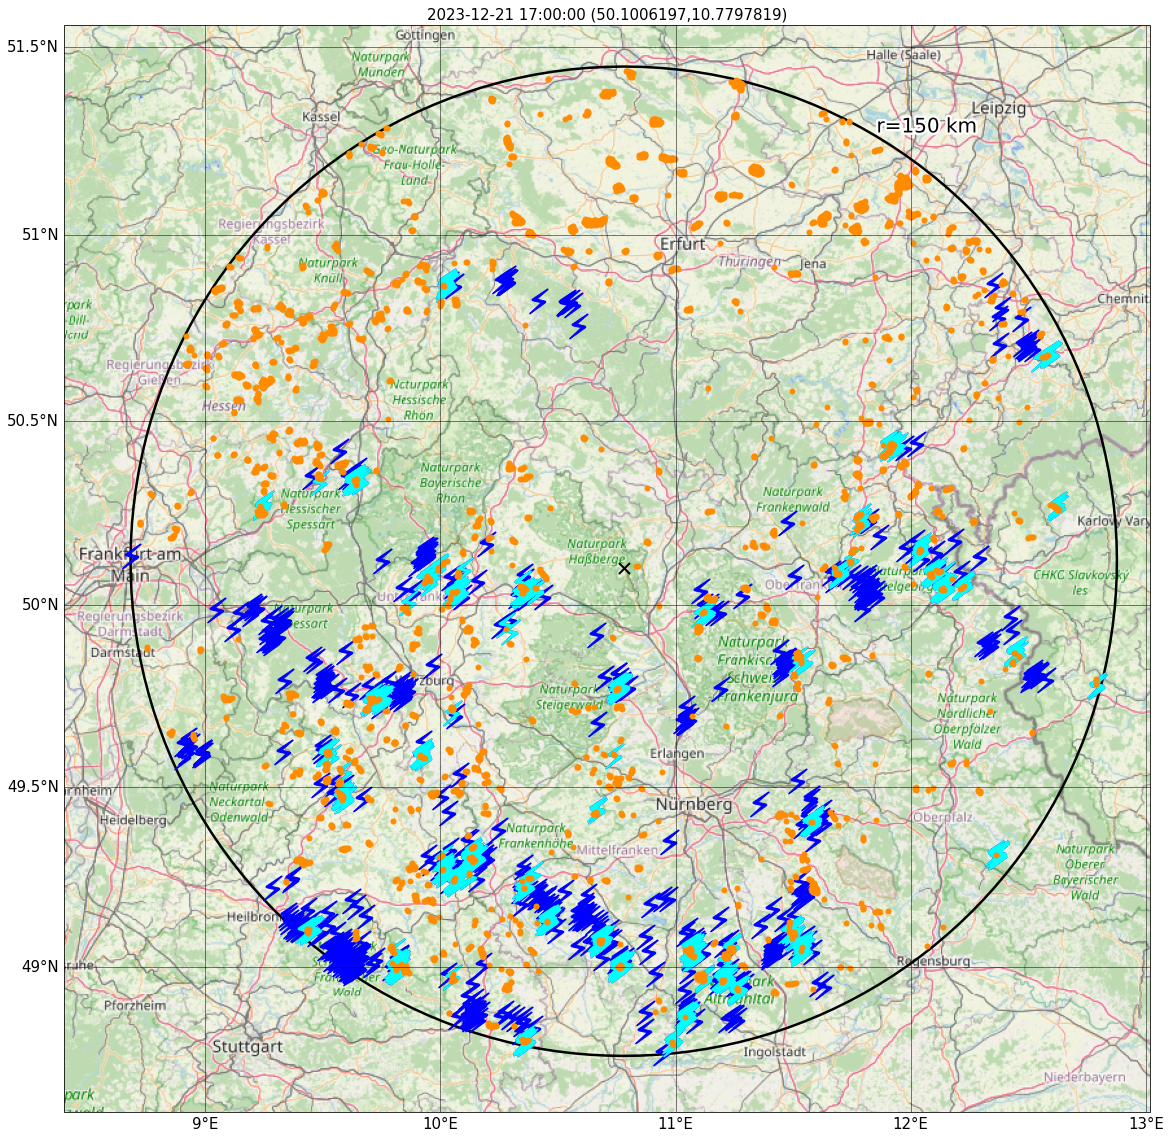

In [490]:
__title__   = 'Plot OpenStreetMap site map'
__version__ = 'v1.0 (2021-03-02)'
__author__  = 'Mathew Lipson'
__email__   = 'm.lipson@unsw.edu.au'

import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.patheffects as pe
import cartopy
import cartopy.geodesic as cgeo
import cartopy.crs as ccrs

import cartopy.io.img_tiles as cimgt
import io
from urllib.request import urlopen, Request
from PIL import Image
import shapely

projpath = '.'

##########################################################################

def main():

    RADIUS = BLITZ_DIST * 1000
    
    # style can be 'map' or 'satellite'

    #for style in ['map','satellite']:

    osm_image(lon, lat, sitename=sitename, style='map', radius=RADIUS)

    return

##########################################################################

def osm_image(lon,lat,sitename='Columbo',style='satellite',radius=500):
    '''This function makes OpenStreetMap satellite or map image with circle and random points.
    Change np.random.seed() number to produce different (reproducable) random patterns of points.
    Also review 'scale' variable'''

    if style=='map':
        ## MAP STYLE
        cimgt.OSM.get_image = image_spoof # reformat web request for street map spoofing
        img = cimgt.OSM() # spoofed, downloaded street map
    elif style =='satellite':
        # SATELLITE STYLE
        cimgt.QuadtreeTiles.get_image = image_spoof # reformat web request for street map spoofing
        img = cimgt.QuadtreeTiles() # spoofed, downloaded street map
    else:
        print('no valid style')

    stroke = [pe.Stroke(linewidth=1, foreground='w'), pe.Normal()]

    ############################################################################

    plt.close('all')
    fig = plt.figure(figsize=(20,20)) # open matplotlib figure
    ax = plt.axes(projection=img.crs) # project using coordinate reference system (CRS) of street map
    data_crs = ccrs.PlateCarree()

    ax.set_title(f'{sitename} ({lat},{lon})',fontsize=15)

    # auto-calculate scale
    #scale = int(120/np.log(radius))
    scale = int(115/np.log(radius))
    scale = (scale<20) and scale or 19

    scale = 8
    
    # or change scale manually
    # NOTE: scale specifications should be selected based on radius
    # but be careful not have both large scale (>16) and large radius (>1000), 
    #  it is forbidden under [OSM policies](https://operations.osmfoundation.org/policies/tiles/)
    # -- 2     = coarse image, select for worldwide or continental scales
    # -- 4-6   = medium coarseness, select for countries and larger states
    # -- 6-10  = medium fineness, select for smaller states, regions, and cities
    # -- 10-12 = fine image, select for city boundaries and zip codes
    # -- 14+   = extremely fine image, select for roads, blocks, buildings

    extent = calc_extent(lon,lat,radius*1.1)
    ax.set_extent(extent) # set extents
    ax.add_image(img, int(scale)) # add OSM with zoom specification

    # add site
    #ax.plot(lon,lat, color='black', marker='x', ms=10, mew=3, transform=data_crs)
    ax.plot(lon,lat, color='black', marker='x', ms=11, mew=2, transform=data_crs)
    
    #lightning = blitz.loc['2021-08-15 16:00:00':'2021-08-15 20:00:00']
    lightning = blitz
    #lightning = blitz.loc['2023-07-06 11:30':'2023-07-06 11:40']
    #ax.plot(lightning.lon,lightning.lat,color='blue',lw=0,marker='$\u21AF$',ms=25,mew=1.0,transform=data_crs)
    #ax.plot(lightning.lon,lightning.lat,color='black',lw=0,marker='$\u26A1$',ms=35,mew=1.0,transform=data_crs)
    ax.plot(lightning.lon,lightning.lat,color='blue',lw=0,marker='$\u26A1$',ms=25,mew=1.0,transform=data_crs)

    ax.plot(blitz.loc[blitz['is_close']==True].lon,blitz.loc[blitz['is_close']==True].lat,color='cyan',lw=0,marker='$\u26A1$',ms=25,mew=1.0,transform=data_crs)

    ax.plot(windturbines.lon,windturbines.lat,color='darkorange',lw=0,marker='o',ms=5,mew=1.0,transform=data_crs)
    #ax.plot(wind_mills['geometry.coordinates'].apply(lambda x: x[0][0] if isinstance(x[0], (list, np.ndarray)) else x).apply(lambda x: x[0]),wind_mills['geometry.coordinates'].apply(lambda x: x[0][0] if isinstance(x[0], (list, np.ndarray)) else x).apply(lambda x: x[1]) ,color='darkorange',lw=0,marker='o',ms=5,mew=1.0,transform=data_crs)


    # Cas jednotlivych bodu
    #for index, row in lightning.iterrows():
    #    ax.text(row.lon, row.lat, row.UTC, color='red', fontsize=10, ha='left',va='bottom', transform=data_crs)


    # add cartopy geodesic circle
    circle_points = cgeo.Geodesic().circle(lon=lon, lat=lat, radius=radius)
    geom = shapely.geometry.Polygon(circle_points)
    ax.add_geometries((geom,), crs=ccrs.PlateCarree(), edgecolor='black', facecolor='none', linewidth=2.5)

    radius_text = cgeo.Geodesic().direct(points=(lon,lat),azimuths=30,distances=radius)[:,0:2][0]
    stroke = [pe.Stroke(linewidth=5, foreground='w'), pe.Normal()]
    ax.text(radius_text[0],radius_text[1],f'r={int(radius/1000)} km', color='black', 
        fontsize=20, ha='left',va='bottom', path_effects=stroke, transform=data_crs)

    gl = ax.gridlines(draw_labels=True, crs=data_crs,
                        color='k',lw=0.5)

    gl.top_labels = False
    gl.right_labels = False
    gl.xformatter = cartopy.mpl.gridliner.LONGITUDE_FORMATTER
    gl.yformatter = cartopy.mpl.gridliner.LATITUDE_FORMATTER

    plt.show()

    fig.savefig(f'./pics/'+sitename+'_windturbines.png', dpi=150, bbox_inches='tight')

    return

def calc_extent(lon,lat,dist):
    '''This function calculates extent of map
    Inputs:
        lat,lon: location in degrees
        dist: dist to edge from centre
    '''

    dist_cnr = np.sqrt(2*dist**2)
    top_left = cgeo.Geodesic().direct(points=(lon,lat),azimuths=-45,distances=dist_cnr)[:,0:2][0]
    bot_right = cgeo.Geodesic().direct(points=(lon,lat),azimuths=135,distances=dist_cnr)[:,0:2][0]

    extent = [top_left[0], bot_right[0], bot_right[1], top_left[1]]

    return extent

def image_spoof(self, tile):
    '''this function reformats web requests from OSM for cartopy
    Heavily based on code by Joshua Hrisko at:
        https://makersportal.com/blog/2020/4/24/geographic-visualizations-in-python-with-cartopy'''

    url = self._image_url(tile)                # get the url of the street map API
    req = Request(url)                         # start request
    req.add_header('User-agent','Anaconda 3')  # add user agent to request
    fh = urlopen(req) 
    im_data = io.BytesIO(fh.read())            # get image
    fh.close()                                 # close url
    img = Image.open(im_data)                  # open image with PIL
    img = img.convert(self.desired_tile_form)  # set image format
    return img, self.tileextent(tile), 'lower' # reformat for cartopy

if __name__ == "__main__":

   main()

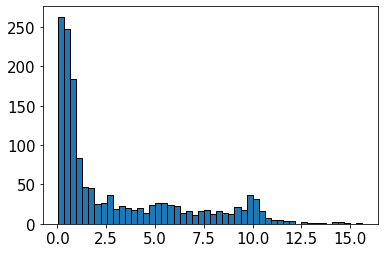

In [491]:
plt.hist(np.amin(distances_wt,axis=1), edgecolor='black', bins=50)
None


In [492]:
json_file = '/home/kakl/vanice/data/tower.geojson'
#json_file = '/home/kakl/vanice/data/mast_tower.geojson'

with open(json_file) as f:
    data = json.load(f)
towers = pd.json_normalize(data,'features')

towers['lon'] = towers['geometry.coordinates'].apply(lambda x: x[0][0] if isinstance(x[0], (list, np.ndarray)) else x).apply(lambda x: x[0])
towers['lat'] = towers['geometry.coordinates'].apply(lambda x: x[0][0] if isinstance(x[0], (list, np.ndarray)) else x).apply(lambda x: x[1])


In [493]:
# Reduction of distant tall structures

towers['lonRad']=np.radians(towers.lon)
towers['latRad']=np.radians(towers.lat)
lonRad=np.radians(lon)
latRad=np.radians(lat)
towers['DlonRad']=lonRad-towers.lonRad
towers['DlatRad']=latRad-towers.latRad
towers['a']=np.sin(towers.DlatRad/2.)**2. + np.cos(towers.latRad) * np.cos(latRad) * np.sin(towers.DlonRad/2.)**2.
towers['km'] = 2. * np.arcsin(np.sqrt(towers.a))*6378.
towers = towers.loc[towers['km'] <= BLITZ_DIST]


In [494]:
# Identify lightning with nearby structures

# Haversine formula for calculating the distance between two points on a sphere
def haversine(lat1, lon1, lat2, lon2):
    R = 6371.0  # Earth's radius in km
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return R * c

# Vectorizing the Haversine formula
vec_haversine = np.vectorize(haversine)

# Converting coordinates to radians
blitz['latRad'] = np.radians(blitz['lat'])
blitz['lonRad'] = np.radians(blitz['lon'])
towers['latRad'] = np.radians(towers['lat'])
towers['lonRad'] = np.radians(towers['lon'])

# Converting pandas.Series to numpy.array
latRad_blitz = blitz['latRad'].to_numpy()
lonRad_blitz = blitz['lonRad'].to_numpy()
latRad_towers = towers['latRad'].to_numpy()
lonRad_towers = towers['lonRad'].to_numpy()

# Calculating distance between each point in 'blitz' and all points in 'structures'
distances_tw = vec_haversine(latRad_blitz[:, np.newaxis], lonRad_blitz[:, np.newaxis],
                          latRad_towers, lonRad_towers)

# Marking points in 'blitz' that are within 1.4 km of any point in 'structures'
blitz['is_close'] = False
blitz['is_close'] = np.any(distances_tw <= (radius_error), axis=1)
veze = len(blitz.loc[blitz['is_close']==True])
blitz['both'] = blitz['vetrnik'] | blitz['is_close']

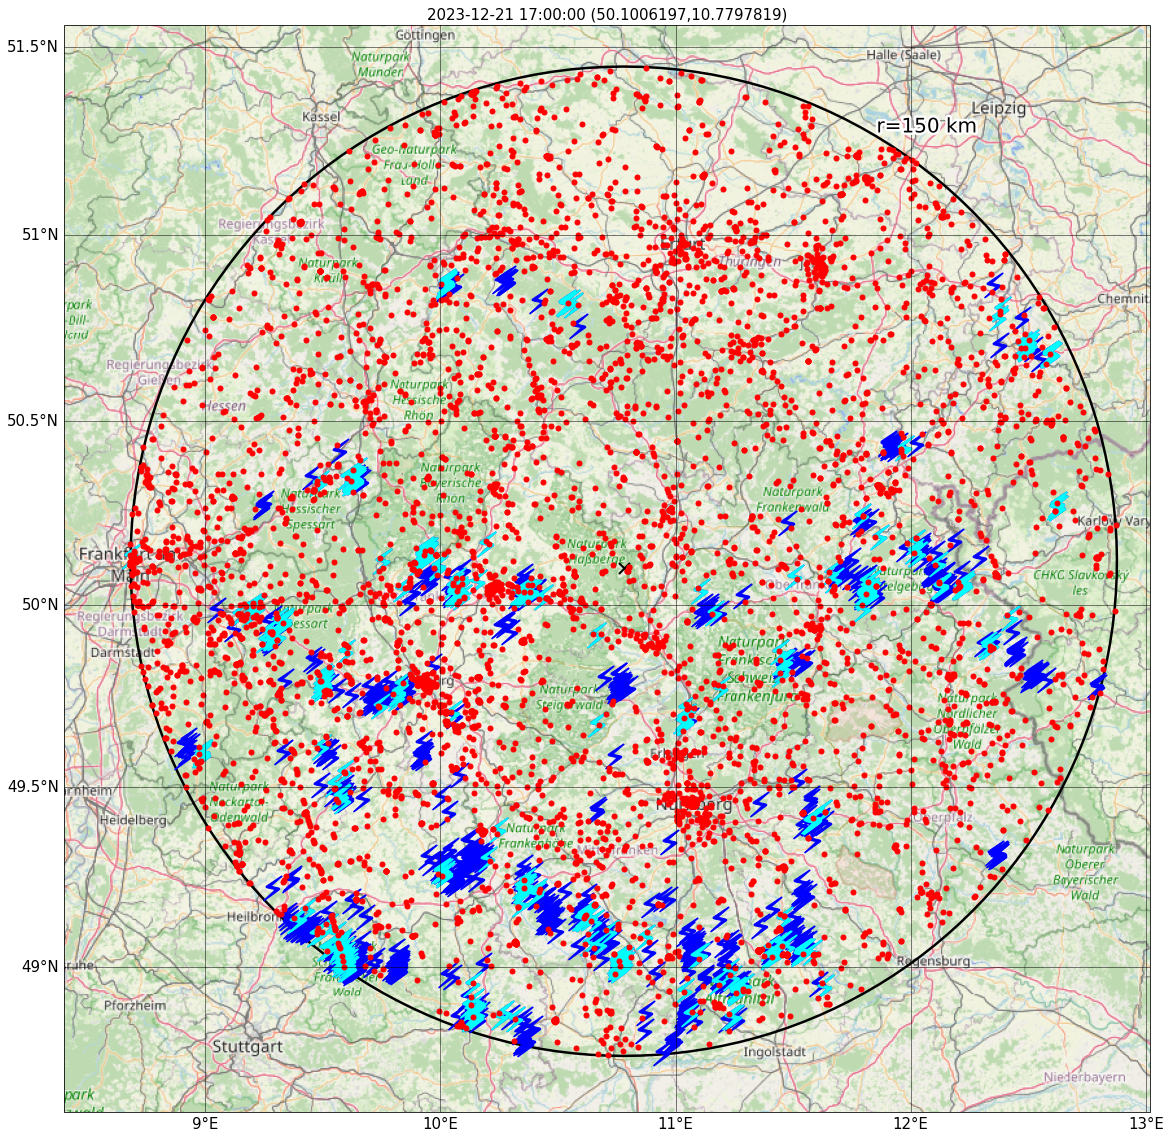

In [495]:
__title__   = 'Plot OpenStreetMap site map'
__version__ = 'v1.0 (2021-03-02)'
__author__  = 'Mathew Lipson'
__email__   = 'm.lipson@unsw.edu.au'

import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.patheffects as pe
import cartopy
import cartopy.geodesic as cgeo
import cartopy.crs as ccrs

import cartopy.io.img_tiles as cimgt
import io
from urllib.request import urlopen, Request
from PIL import Image
import shapely

projpath = '.'

##########################################################################

def main():

    RADIUS = BLITZ_DIST * 1000
    
    # style can be 'map' or 'satellite'

    #for style in ['map','satellite']:

    osm_image(lon, lat, sitename=sitename, style='map', radius=RADIUS)

    return

##########################################################################

def osm_image(lon,lat,sitename='Columbo',style='satellite',radius=500):
    '''This function makes OpenStreetMap satellite or map image with circle and random points.
    Change np.random.seed() number to produce different (reproducable) random patterns of points.
    Also review 'scale' variable'''

    if style=='map':
        ## MAP STYLE
        cimgt.OSM.get_image = image_spoof # reformat web request for street map spoofing
        img = cimgt.OSM() # spoofed, downloaded street map
    elif style =='satellite':
        # SATELLITE STYLE
        cimgt.QuadtreeTiles.get_image = image_spoof # reformat web request for street map spoofing
        img = cimgt.QuadtreeTiles() # spoofed, downloaded street map
    else:
        print('no valid style')

    stroke = [pe.Stroke(linewidth=1, foreground='w'), pe.Normal()]

    ############################################################################

    plt.close('all')
    fig = plt.figure(figsize=(20,20)) # open matplotlib figure
    ax = plt.axes(projection=img.crs) # project using coordinate reference system (CRS) of street map
    data_crs = ccrs.PlateCarree()

    ax.set_title(f'{sitename} ({lat},{lon})',fontsize=15)

    # auto-calculate scale
    #scale = int(120/np.log(radius))
    scale = int(115/np.log(radius))
    scale = (scale<20) and scale or 19

    scale = 8
    
    # or change scale manually
    # NOTE: scale specifications should be selected based on radius
    # but be careful not have both large scale (>16) and large radius (>1000), 
    #  it is forbidden under [OSM policies](https://operations.osmfoundation.org/policies/tiles/)
    # -- 2     = coarse image, select for worldwide or continental scales
    # -- 4-6   = medium coarseness, select for countries and larger states
    # -- 6-10  = medium fineness, select for smaller states, regions, and cities
    # -- 10-12 = fine image, select for city boundaries and zip codes
    # -- 14+   = extremely fine image, select for roads, blocks, buildings

    extent = calc_extent(lon,lat,radius*1.1)
    ax.set_extent(extent) # set extents
    ax.add_image(img, int(scale)) # add OSM with zoom specification

    # add site
    #ax.plot(lon,lat, color='black', marker='x', ms=10, mew=3, transform=data_crs)
    ax.plot(lon,lat, color='black', marker='x', ms=11, mew=2, transform=data_crs)
    
    #lightning = blitz.loc['2021-08-15 16:00:00':'2021-08-15 20:00:00']
    lightning = blitz
    #lightning = blitz.loc['2023-07-06 11:30':'2023-07-06 11:40']
    #ax.plot(lightning.lon,lightning.lat,color='blue',lw=0,marker='$\u21AF$',ms=25,mew=1.0,transform=data_crs)
    #ax.plot(lightning.lon,lightning.lat,color='black',lw=0,marker='$\u26A1$',ms=35,mew=1.0,transform=data_crs)
    ax.plot(lightning.lon,lightning.lat,color='blue',lw=0,marker='$\u26A1$',ms=25,mew=1.0,transform=data_crs)

    ax.plot(blitz.loc[blitz['is_close']==True].lon,blitz.loc[blitz['is_close']==True].lat,color='cyan',lw=0,marker='$\u26A1$',ms=25,mew=1.0,transform=data_crs)

    ax.plot(towers.lon,towers.lat,color='red',lw=0,marker='o',ms=5,mew=1.0,transform=data_crs)
    #ax.plot(wind_mills['geometry.coordinates'].apply(lambda x: x[0][0] if isinstance(x[0], (list, np.ndarray)) else x).apply(lambda x: x[0]),wind_mills['geometry.coordinates'].apply(lambda x: x[0][0] if isinstance(x[0], (list, np.ndarray)) else x).apply(lambda x: x[1]) ,color='darkorange',lw=0,marker='o',ms=5,mew=1.0,transform=data_crs)


    # Cas jednotlivych bodu
    #for index, row in lightning.iterrows():
    #    ax.text(row.lon, row.lat, row.UTC, color='red', fontsize=10, ha='left',va='bottom', transform=data_crs)


    # add cartopy geodesic circle
    circle_points = cgeo.Geodesic().circle(lon=lon, lat=lat, radius=radius)
    geom = shapely.geometry.Polygon(circle_points)
    ax.add_geometries((geom,), crs=ccrs.PlateCarree(), edgecolor='black', facecolor='none', linewidth=2.5)

    radius_text = cgeo.Geodesic().direct(points=(lon,lat),azimuths=30,distances=radius)[:,0:2][0]
    stroke = [pe.Stroke(linewidth=5, foreground='w'), pe.Normal()]
    ax.text(radius_text[0],radius_text[1],f'r={int(radius/1000)} km', color='black', 
        fontsize=20, ha='left',va='bottom', path_effects=stroke, transform=data_crs)

    gl = ax.gridlines(draw_labels=True, crs=data_crs,
                        color='k',lw=0.5)

    gl.top_labels = False
    gl.right_labels = False
    gl.xformatter = cartopy.mpl.gridliner.LONGITUDE_FORMATTER
    gl.yformatter = cartopy.mpl.gridliner.LATITUDE_FORMATTER

    plt.show()

    fig.savefig(f'./pics/'+sitename+'_towers.png', dpi=150, bbox_inches='tight')

    return

def calc_extent(lon,lat,dist):
    '''This function calculates extent of map
    Inputs:
        lat,lon: location in degrees
        dist: dist to edge from centre
    '''

    dist_cnr = np.sqrt(2*dist**2)
    top_left = cgeo.Geodesic().direct(points=(lon,lat),azimuths=-45,distances=dist_cnr)[:,0:2][0]
    bot_right = cgeo.Geodesic().direct(points=(lon,lat),azimuths=135,distances=dist_cnr)[:,0:2][0]

    extent = [top_left[0], bot_right[0], bot_right[1], top_left[1]]

    return extent

def image_spoof(self, tile):
    '''this function reformats web requests from OSM for cartopy
    Heavily based on code by Joshua Hrisko at:
        https://makersportal.com/blog/2020/4/24/geographic-visualizations-in-python-with-cartopy'''

    url = self._image_url(tile)                # get the url of the street map API
    req = Request(url)                         # start request
    req.add_header('User-agent','Anaconda 3')  # add user agent to request
    fh = urlopen(req) 
    im_data = io.BytesIO(fh.read())            # get image
    fh.close()                                 # close url
    img = Image.open(im_data)                  # open image with PIL
    img = img.convert(self.desired_tile_form)  # set image format
    return img, self.tileextent(tile), 'lower' # reformat for cartopy

if __name__ == "__main__":

   main()

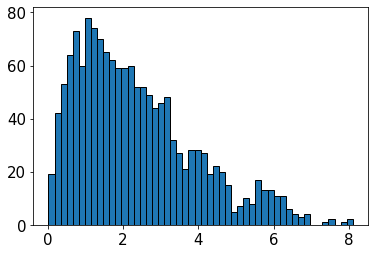

In [496]:
plt.hist(np.amin(distances_tw,axis=1), edgecolor='black', bins=50)
None


Median wt 1.1 [km]
Median tw 2.0 [km]
Mean wt 3.0 [km]
Mean tw 2.3 [km]


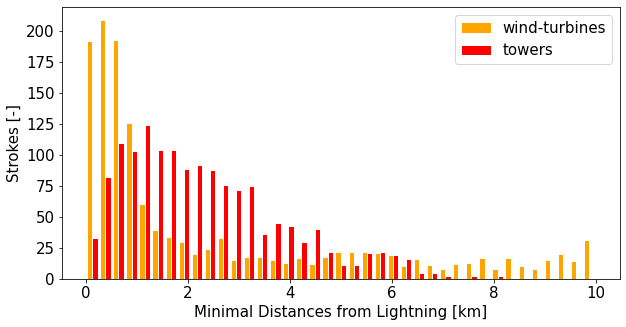

In [497]:
import statistics
#plt.figure(figsize=(10,5), facecolor='lightyellow')
plt.figure(figsize=(10,5))
matplotlib.rcParams.update({'font.size': 15})

#plt.hist(np.amin(distances_wt,axis=1), bins=50)
plt.hist((np.amin(distances_wt, axis=1),np.amin(distances_tw, axis=1)),edgecolor='white',color=('orange','red'),label=('wind-turbines','towers'),bins=np.linspace(0, 10, 40))
plt.legend()
plt.xlabel('Minimal Distances from Lightning [km]')
plt.ylabel('Strokes [-]')
print('Median wt', round(statistics.median(np.amin(distances_wt, axis=1)),1), '[km]')
print('Median tw', round(statistics.median(np.amin(distances_tw, axis=1)),1), '[km]')
print('Mean wt', round(statistics.mean(np.amin(distances_wt, axis=1)),1), '[km]')
print('Mean tw', round(statistics.mean(np.amin(distances_tw, axis=1)),1), '[km]')


In [498]:
celkem = len(blitz)
bez = len(blitz.loc[blitz['both']==False])
print(sitename.split()[0])
print('Lightning\t', celkem, '\t', celkem/2)
print('Towers\t\t', veze, '\t', round(veze/(celkem/100),0),"%")
print('Wind-turbines\t', vetrniky, '\t', round(vetrniky/(celkem/100),0),"%")
print('ratio\t\t', round(veze/vetrniky,1))
print('Nothing found\t', bez, '\t', round(bez/(celkem/100),0))

2023-12-21
Lightning	 1486 	 743.0
Towers		 506 	 34.0 %
Wind-turbines	 798 	 54.0 %
ratio		 0.6
Nothing found	 364 	 24.0


In [499]:
#blitz.loc[blitz['both']==False]

In [500]:
assert False

AssertionError: 

In [ ]:
print('towers', len(towers))
print('wind-turbines', len(windturbines))
print('ratio', round(len(towers)/len(windturbines),1))

In [ ]:
# Identify distances with nearby structures

# Calculating distance between each point in 'blitz' and all points in 'structures'
distances = vec_haversine(latRad_windturbines[:, np.newaxis], lonRad_windturbines[:, np.newaxis],
                          latRad_towers, lonRad_towers)



In [ ]:
plt.figure(figsize=(10,5))
matplotlib.rcParams.update({'font.size': 15})

#dist = distances.flatten()
#dist[dist != 0]
dist = np.amin(distances, axis=1)
plt.hist(dist, edgecolor='black', bins=50)
print('Median', round(statistics.median(dist),1), '[km]')
print('Mean', round(statistics.mean(dist),1), '[km]')
plt.xlabel('Minimal Distances between Wind-turbines and Towers [km]')
plt.ylabel('Cases [-]')


In [ ]:
# Identify distances with nearby structures

# Calculating distance between each point in 'blitz' and all points in 'structures'
distances = vec_haversine(latRad_towers[:, np.newaxis], lonRad_towers[:, np.newaxis],
                          latRad_towers, lonRad_towers)



In [ ]:
distances = np.where(distances==0, np.nan, distances)

In [ ]:
plt.figure(figsize=(10,5))
matplotlib.rcParams.update({'font.size': 15})

#dist = distances.flatten()
#dist[dist != 0]
dist = np.nanmin(distances, axis=1)
plt.hist(dist, edgecolor='black', bins=50)
print('Median', round(statistics.median(dist),1), '[km]')
print('Mean', round(statistics.mean(dist),1), '[km]')
plt.xlabel('Minimal Distances between Towers [km]')
plt.ylabel('Cases [-]')


In [ ]:
# Identify distances with nearby structures

# Calculating distance between each point in 'blitz' and all points in 'structures'
distances = vec_haversine(latRad_windturbines[:, np.newaxis], lonRad_windturbines[:, np.newaxis],
                          latRad_windturbines, lonRad_windturbines)



In [ ]:
distances = np.where(distances==0, np.nan, distances)

In [ ]:
plt.figure(figsize=(10,5))
matplotlib.rcParams.update({'font.size': 15})

#dist = distances.flatten()
#dist[dist != 0]
dist = np.nanmin(distances, axis=1)
plt.hist(dist, edgecolor='black', bins=50)
print('Median', round(statistics.median(dist),1), '[km]')
print('Mean', round(statistics.mean(dist),1), '[km]')
plt.xlabel('Minimal Distances between Wind-turbines [km]')
plt.ylabel('Cases [-]')
